In [245]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [246]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [247]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,10.65,9.57,10.04,10.65,1014,1014,1007,69,0.61,1709834400,2024-03-07 19:00:00,07/03/2024 19:00:00,19
1,9.64,7.29,7.63,9.64,1014,1014,1006,70,2.01,1709845200,2024-03-07 22:00:00,07/03/2024 22:00:00,22
2,7.23,4.53,5.52,7.23,1012,1012,1004,73,1.71,1709856000,2024-03-08 01:00:00,08/03/2024 01:00:00,01
3,4.49,1.26,4.49,4.49,1009,1009,1002,80,0.00,1709866800,2024-03-08 04:00:00,08/03/2024 04:00:00,04
4,3.63,0.17,3.63,3.63,1007,1007,1000,80,0.00,1709877600,2024-03-08 07:00:00,08/03/2024 07:00:00,07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,7.04,5.64,7.04,7.04,1012,1012,1004,86,0.00,1710212400,2024-03-12 04:00:00,12/03/2024 04:00:00,04
36,6.58,6.58,6.58,6.58,1013,1013,1006,88,0.00,1710223200,2024-03-12 07:00:00,12/03/2024 07:00:00,07
37,8.04,7.15,8.04,8.04,1014,1014,1007,82,0.00,1710234000,2024-03-12 10:00:00,12/03/2024 10:00:00,10
38,11.25,9.97,11.25,11.25,1014,1014,1007,59,0.00,1710244800,2024-03-12 13:00:00,12/03/2024 13:00:00,13


In [248]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('07/03/2024 19:00:00', '12/03/2024 16:00:00')

<AxesSubplot: >

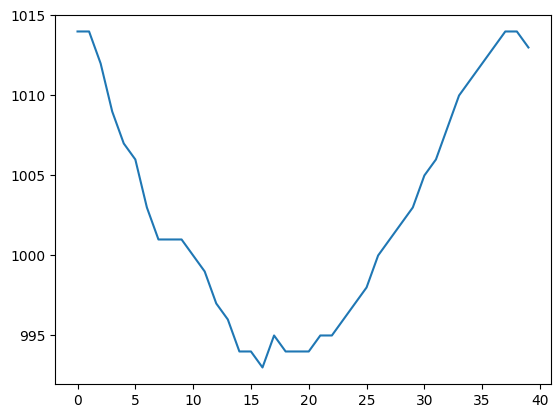

In [249]:
(current.pressure).plot()


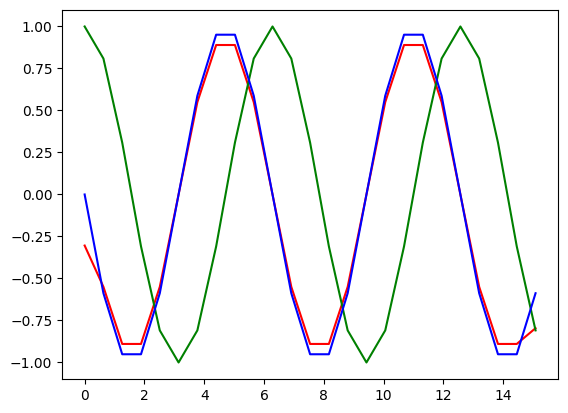

In [250]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

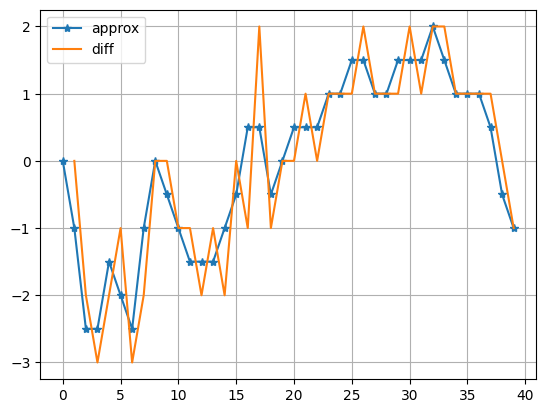

In [251]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [252]:
dy.diff()

0     NaN
1     0.0
2    -2.0
3    -3.0
4    -2.0
     ... 
35    1.0
36    1.0
37    1.0
38    0.0
39   -1.0
Name: pressure, Length: 40, dtype: float64

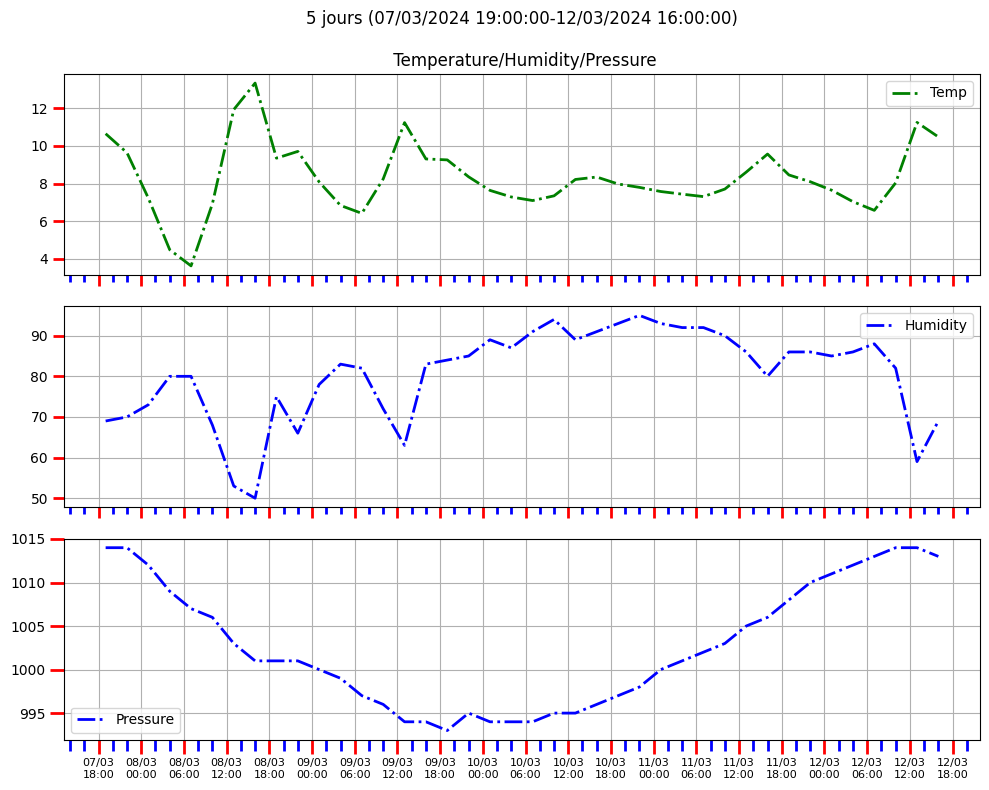

In [253]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [254]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


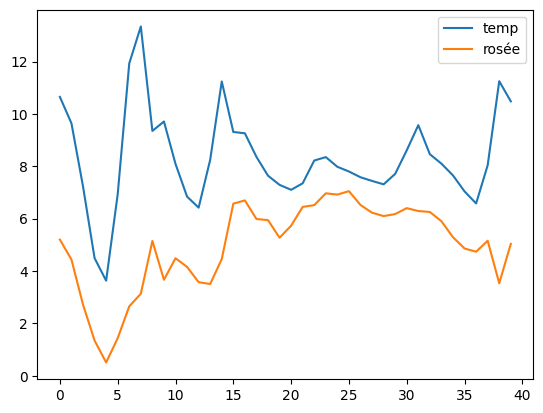

In [255]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


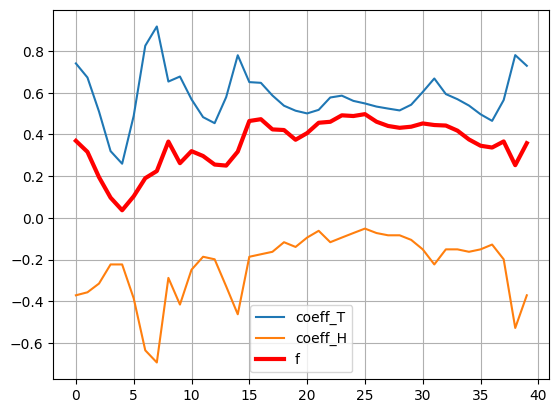

In [256]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

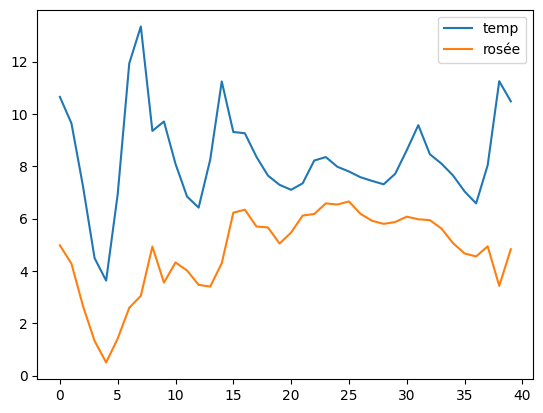

In [257]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


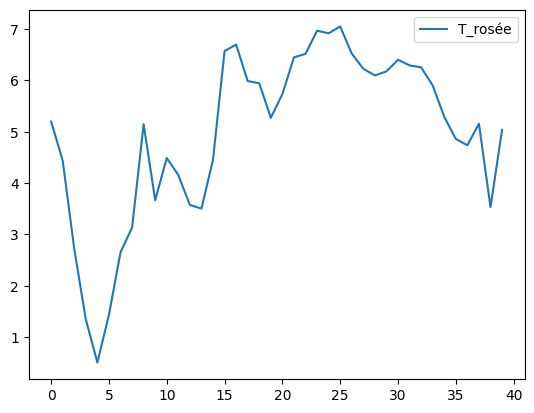

In [258]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [259]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.369526
 1     0.316418
 2     0.195076
 3     0.097028
 4     0.036626
         ...   
 35    0.345952
 36    0.337357
 37    0.366580
 38    0.252795
 39    0.358204
 Length: 40, dtype: float64,
 0    -0.317424
 1    -0.307910
 2    -0.277752
 3    -0.199913
 4    -0.204291
         ...   
 35   -0.114805
 36   -0.094101
 37   -0.157496
 38   -0.471117
 39   -0.318241
 Length: 40, dtype: float64)

In [260]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.371064
 1    -0.356675
 2    -0.314711
 3    -0.223144
 4    -0.223144
         ...   
 35   -0.150823
 36   -0.127833
 37   -0.198451
 38   -0.527633
 39   -0.371064
 Name: humidity, Length: 40, dtype: float64)

In [261]:
dewpoint(current.temp[0],current.humidity[0]/100)

(10.65, 5.197273264118346, 5.4527267358816545)

In [262]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0     10.65
 1      9.64
 2      7.23
 3      4.49
 4      3.63
       ...  
 35     7.04
 36     6.58
 37     8.04
 38    11.25
 39    10.48
 Name: temp, Length: 40, dtype: float64,
 0     5.197273
 1     4.436381
 2     2.715655
 3     1.343012
 4     0.505178
         ...   
 35    4.858938
 36    4.735803
 37    5.154943
 38    3.531096
 39    5.034654
 Length: 40, dtype: float64,
 0     5.452727
 1     5.203619
 2     4.514345
 3     3.146988
 4     3.124822
         ...   
 35    2.181062
 36    1.844197
 37    2.885057
 38    7.718904
 39    5.445346
 Length: 40, dtype: float64)

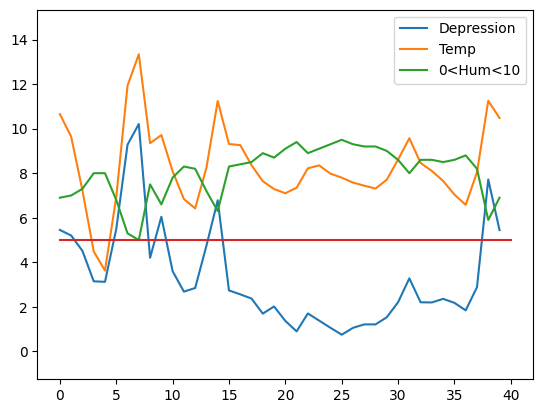

In [263]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [264]:
current.temp.head(),current.h_time.head()

(0    10.65
 1     9.64
 2     7.23
 3     4.49
 4     3.63
 Name: temp, dtype: float64,
 0    19
 1    22
 2    01
 3    04
 4    07
 Name: h_time, dtype: object)

In [265]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,19,10.65,5.197273
1,22,9.64,4.436381
2,01,7.23,2.715655
3,04,4.49,1.343012
4,07,3.63,0.505178
...,...,...,...
35,04,7.04,4.858938
36,07,6.58,4.735803
37,10,8.04,5.154943
38,13,11.25,3.531096


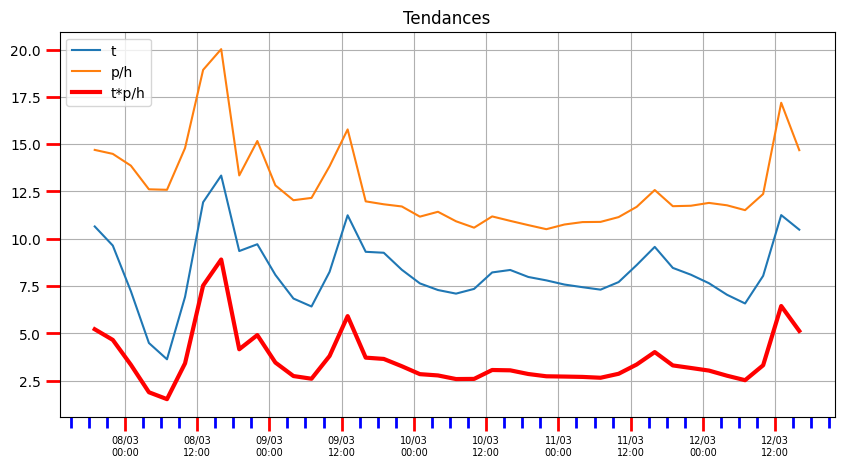

In [266]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

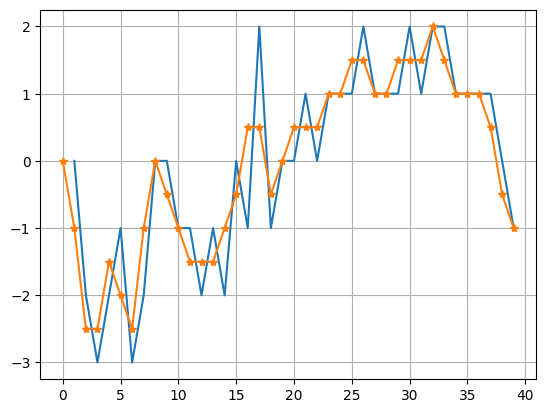

In [267]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [268]:
len(dy)

40

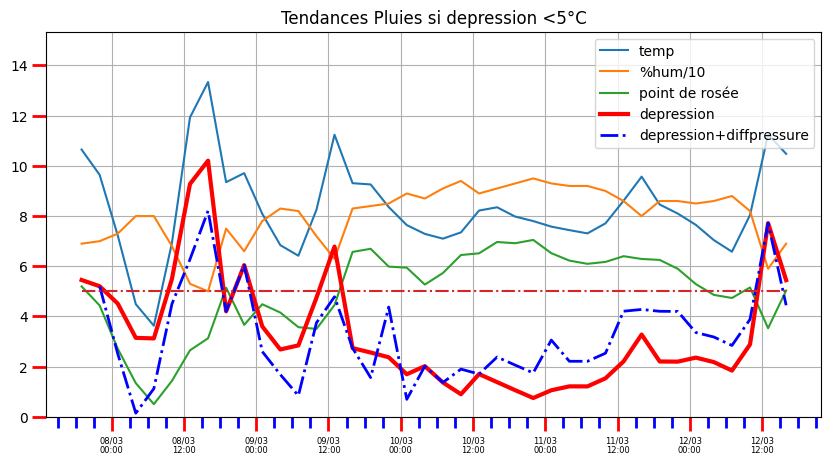

In [269]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots()

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(0,max(current.temp)+2)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [270]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')

In [271]:
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,07/03/2024 19:00:00,10.65,5.452727,beau temps
1,07/03/2024 22:00:00,9.64,5.203619,beau temps
2,08/03/2024 01:00:00,7.23,4.514345,pluie
3,08/03/2024 04:00:00,4.49,3.146988,pluie
4,08/03/2024 07:00:00,3.63,3.124822,pluie
5,08/03/2024 10:00:00,6.93,5.495879,beau temps
6,08/03/2024 13:00:00,11.93,9.279216,beau temps
7,08/03/2024 16:00:00,13.34,10.208460,beau temps
8,08/03/2024 19:00:00,9.35,4.204422,pluie
9,08/03/2024 22:00:00,9.71,6.044469,beau temps


In [272]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,10/03/2024 07:00:00,7.10,1.369073,pluie
21,10/03/2024 10:00:00,7.35,0.901789,pluie
22,10/03/2024 13:00:00,8.22,1.704892,pluie
23,10/03/2024 16:00:00,8.35,1.383050,pluie
24,10/03/2024 19:00:00,7.98,1.062422,pluie
25,10/03/2024 22:00:00,7.80,0.750779,pluie
26,11/03/2024 01:00:00,7.58,1.058973,pluie
27,11/03/2024 04:00:00,7.44,1.214563,pluie
28,11/03/2024 07:00:00,7.31,1.213278,pluie
29,11/03/2024 10:00:00,7.71,1.536081,pluie


In [273]:
current.h_date

0     07/03/2024 19:00:00
1     07/03/2024 22:00:00
2     08/03/2024 01:00:00
3     08/03/2024 04:00:00
4     08/03/2024 07:00:00
             ...         
35    12/03/2024 04:00:00
36    12/03/2024 07:00:00
37    12/03/2024 10:00:00
38    12/03/2024 13:00:00
39    12/03/2024 16:00:00
Name: h_date, Length: 40, dtype: object